# UAS Pembelajaran Mesin 2019/2020
## Nama/NIM: Rayhan Naufal Ramadhan/(17/412651/PA/17970)
## Kelas: B

### **Preprocessing**

In [1]:
# Import the necessary libraries
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os

In [2]:
train_path = "./flowers/training_set/"
test_path = "./flowers/test_set/"

train_folders = os.listdir(train_path)
test_folders = os.listdir(test_path)

print(train_folders, test_folders)

['dandelion', 'rose', 'sunflower'] ['dandelion', 'rose', 'sunflower']


In [3]:
def preprocess_image_cnn(folders, path):
    # Import the images and resize them to a 160*120 size
    # Also generate the corresponding labels
    data_labels = []
    data_images = []
    size = 160, 120
    
    for folder in folders:
        for file in os.listdir(os.path.join(path, folder)):
            if file.endswith("jpg"):
                data_labels.append(folder)
                img = cv2.imread(os.path.join(path, folder, file))
                im = cv2.resize(img,size)
                data_images.append(im)
            else:
                continue
    
    #Transform the image array to a numpy type
    images = np.array(data_images)
    
    # Reduce the RGB values between 0 and 1
    images = images.astype('float32') / 255.0
    
    # Extract the labels
    label_dummies = pd.get_dummies(data_labels)
    labels = label_dummies.values.argmax(1)
    
    return images, labels

In [4]:
X_train, y_train = preprocess_image_cnn(train_folders, train_path)
X_test, y_test = preprocess_image_cnn(test_folders, test_path)

print(X_train.shape, X_test.shape)
y_test

(240, 120, 160, 3) (60, 120, 160, 3)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [7]:
def preprocess_image_mlp(folders, path):
    # Import the images and resize them to a 320*240 size
    # Also generate the corresponding labels
    data_labels = []
    data_images = []
    size = 320, 240
    
    for folder in folders:
        for file in os.listdir(os.path.join(path, folder)):
            if file.endswith("jpg"):
                data_labels.append(folder)
                img = cv2.imread(os.path.join(path, folder, file))
                im = cv2.resize(img,size)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                im = im.flatten()
                im = im.astype('float32') / 255.0
                im = np.append([-1], im)
                data_images.append(im)
            else:
                continue
    
    #Transform the image array to a numpy type
    images = np.array(data_images)
    
    # Extract the labels
    label_dummies = pd.get_dummies(data_labels)
    labels = label_dummies.values.argmax(1)
    
    return images, labels

In [8]:
X_mlp_train, y_mlp_train = preprocess_image_mlp(train_folders, train_path)
X_mlp_test, y_mlp_test = preprocess_image_mlp(test_folders, test_path)

print(X_mlp_train.shape)
y_mlp_test

(240, 76801)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [9]:
def one_hot_encoding(target):
    new_target = np.eye(np.max(target) + 1)[target]
    return new_target

y_mlp_train = one_hot_encoding(y_mlp_train)
y_mlp_test = one_hot_encoding(y_mlp_test)

y_mlp_test[0]

array([1., 0., 0.])

# **Implementasi Multi Layer Perceptron**

In [10]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    theta1 = np.random.randn(n_hidden, n_inputs + 1)
    theta2 = np.random.randn(n_outputs, n_hidden + 1)
    
    return theta1, theta2

In [11]:
def sigmoid_function(z):
    z = z if np.isscalar(z) else np.asarray(z)
    sigmoid_value = 1.0 / (1.0 + np.exp(-z))
    return sigmoid_value

In [12]:
def gradient_sigmoid_function(z):
    z = z if np.isscalar(z) else np.asarray(z)
    grad_sigmoid = z * (1.0 - z)
    return grad_sigmoid

In [13]:
def cost_function(expected, target):
    cost = np.sum(np.square(expected - target))
    return cost

In [14]:
def get_neuron_value(theta, inputs):
    return sigmoid_function(np.dot(inputs, theta.T))

In [15]:
def forward_propagation(feature, theta1, theta2):
    hidden_neuron = get_neuron_value(theta1, feature)
    bias = -1 * np.ones((hidden_neuron.shape[0],1))
    hidden_neuron = np.append(bias, hidden_neuron, axis=1)
    output_neuron = get_neuron_value(theta2, hidden_neuron)
            
    return hidden_neuron, output_neuron

In [16]:
def predict(output):
    prediction = np.zeros(output.shape)
    for i in range(output.shape[0]):
        max_val = np.amax(output_neuron[i])
        for j in range(output.shape[1]):
            if(output[i][j] == max_val):
                prediction[i][j] = 1
            else:
                prediction[i][j] = 0
    return prediction

In [17]:
def get_hidden_layer_error(next_layer_error, theta, neuron_value):
    error = np.dot(next_layer_error, theta) * gradient_sigmoid_function(neuron_value)
    
    #delete error for bias neuron
    return np.delete(error, 0, axis=1)

In [18]:
def set_delta(error, neuron_val, target):
    delta = np.dot(error.T, neuron_val)
    return delta / len(target)

In [19]:
def update_weight(theta, delta):
    learning_rate = 0.1
    return theta - learning_rate * delta

In [20]:
def back_propagation(feature, target, hidden_neuron, output_neuron, theta1, theta2):
    output_error = (output_neuron - target) * gradient_sigmoid_function(output_neuron)
    hidden_error = get_hidden_layer_error(output_error, theta2, hidden_neuron)
    
    input_delta = set_delta(hidden_error, feature, target)
    hidden_delta = set_delta(output_error, hidden_neuron, target)
    
    new_theta1 = update_weight(theta1, input_delta)
    new_theta2 = update_weight(theta2, hidden_delta)
    
    return new_theta1, new_theta2

In [21]:
def calculate_accuracy(prediction, target):
    correct = 0
    for i in range(len(target)):
        if all(prediction[i] == target[i]):
            correct += 1
    return correct / float(len(target))

In [118]:
input_layer = 320 * 240
hidden_layer = 32
output_layer = 3
theta1, theta2 = initialize_network(input_layer, hidden_layer, output_layer)
train_error = []
train_accuracy = []
test_error = []
test_accuracy = []
epoch = 300

In [123]:
for i in range(epoch):
    hidden_neuron, output_neuron = forward_propagation(X_mlp_train, theta1, theta2)
    acc = calculate_accuracy(predict(output_neuron), y_mlp_train)
    cost = cost_function(output_neuron, y_mlp_train)
    train_accuracy.append(acc)
    train_error.append(cost)
    
    theta1, theta2 = back_propagation(X_mlp_train, y_mlp_train, hidden_neuron, output_neuron, theta1, theta2)
    
    hidden_neuron, output_neuron = forward_propagation(X_mlp_test, theta1, theta2)
    acc = calculate_accuracy(predict(output_neuron), y_mlp_test)
    cost = cost_function(output_neuron, y_mlp_test)
    test_accuracy.append(acc)
    test_error.append(cost)

In [91]:
print(output_neuron)

[[0.00340575 0.2560132  0.86071919]
 [0.35283137 0.50256537 0.13576242]
 [0.35697352 0.27622766 0.20835577]
 [0.08783003 0.2148281  0.14778014]
 [0.25918172 0.34722374 0.8243663 ]
 [0.94355709 0.2046465  0.01419648]
 [0.19329964 0.25803558 0.14203388]
 [0.06649959 0.85896689 0.13033212]
 [0.11515217 0.09853855 0.31804836]
 [0.04867597 0.25291977 0.63894656]
 [0.23717252 0.30076585 0.68330513]
 [0.93452301 0.04659463 0.3694593 ]
 [0.2674637  0.93648589 0.26782914]
 [0.0142381  0.42939391 0.54193394]
 [0.04113704 0.43870551 0.24283913]
 [0.06618583 0.20034793 0.90379165]
 [0.69073647 0.40976525 0.51125237]
 [0.17138151 0.32323188 0.01446578]
 [0.0850095  0.23656481 0.33881879]
 [0.88208949 0.73703628 0.66442152]
 [0.39107947 0.59255157 0.35267712]
 [0.48895487 0.00648047 0.11069779]
 [0.13393501 0.76031398 0.39773545]
 [0.04726268 0.1210323  0.20039644]
 [0.10019882 0.1782174  0.00949574]
 [0.13336673 0.09823027 0.03398383]
 [0.16667449 0.94150008 0.7770148 ]
 [0.11542371 0.27498652 0.03

In [92]:
def visualize_mlp(train, test, ylabel, title):
    plt.plot(np.arange(len(train)), train, label='Train')
    plt.plot(np.arange(len(test)), test, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

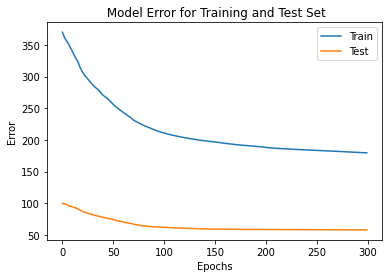

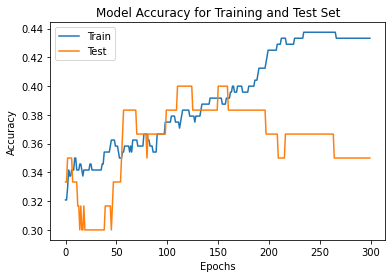

In [120]:
visualize_mlp(train_error, test_error, 'Error', ' Model Error for Training and Test Set')
visualize_mlp(train_accuracy, test_accuracy, 'Accuracy', 'Model Accuracy for Training and Test Set')

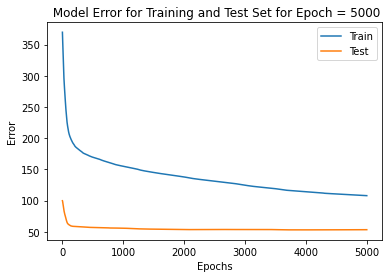

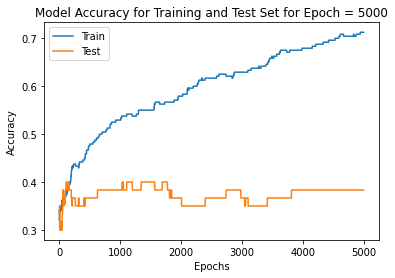

In [126]:
visualize_mlp(train_error, test_error, 'Error', ' Model Error for Training and Test Set for Epoch = 5000')
visualize_mlp(train_accuracy, test_accuracy, 'Accuracy', 'Model Accuracy for Training and Test Set for Epoch = 5000')

# **Implementasi Convolutional Neural Network**

In [96]:
# Develop a sequential model using tensorflow keras
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, input_shape = (120, 160, 3), activation = 'sigmoid'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'sigmoid'),
    keras.layers.Dense(3, activation = 'sigmoid')
])

In [97]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
result = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 300)
result = pd.DataFrame(result.history)

Train on 240 samples, validate on 60 samples
Epoch 1/300
240/240 [==============================] - 6s 26ms/sample - loss: 1.1501 - accuracy: 0.3500 - val_loss: 1.1410 - val_accuracy: 0.3333
Epoch 2/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.1341 - accuracy: 0.3333 - val_loss: 1.1246 - val_accuracy: 0.3333
Epoch 3/300
240/240 [==============================] - 4s 15ms/sample - loss: 1.1203 - accuracy: 0.3333 - val_loss: 1.1156 - val_accuracy: 0.3333
Epoch 4/300
240/240 [==============================] - 4s 15ms/sample - loss: 1.1139 - accuracy: 0.3333 - val_loss: 1.1102 - val_accuracy: 0.3333
Epoch 5/300
240/240 [==============================] - 4s 15ms/sample - loss: 1.1105 - accuracy: 0.3333 - val_loss: 1.1072 - val_accuracy: 0.3333
Epoch 6/300
240/240 [==============================] - 4s 15ms/sample - loss: 1.1065 - accuracy: 0.3333 - val_loss: 1.1059 - val_accuracy: 0.3333
Epoch 7/300
240/240 [==============================] - 4s 15ms/sample - loss: 1

Epoch 112/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 113/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 114/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 115/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 116/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 117/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 118/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_

240/240 [==============================] - 4s 16ms/sample - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 223/300
240/240 [==============================] - 4s 17ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 224/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 225/300
240/240 [==============================] - 4s 17ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 226/300
240/240 [==============================] - 4s 17ms/sample - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 227/300
240/240 [==============================] - 4s 17ms/sample - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 228/300
240/240 [==============================] - 4s 16ms/sample - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 -

In [99]:
result

loss  accuracy  val_loss  val_accuracy
0    1.150141  0.350000  1.141048      0.333333
1    1.134104  0.333333  1.124631      0.333333
2    1.120323  0.333333  1.115568      0.333333
3    1.113906  0.333333  1.110247      0.333333
4    1.110451  0.333333  1.107215      0.333333
..        ...       ...       ...           ...
295  1.098624  0.333333  1.098615      0.333333
296  1.098641  0.333333  1.098616      0.333333
297  1.098669  0.333333  1.098615      0.333333
298  1.098660  0.333333  1.098614      0.333333
299  1.098631  0.333333  1.098615      0.333333

[300 rows x 4 columns]

In [100]:
def visualize_cnn(result, title, ylabel):
    for column in result:
        plt.plot(np.arange(300), result[column], label=column)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

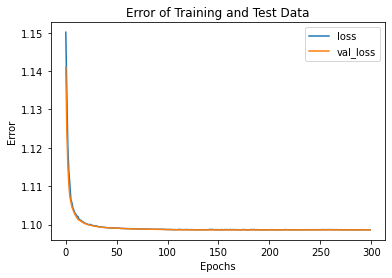

In [101]:
visualize_cnn(result[['loss', 'val_loss']], 'Error of Training and Test Data', 'Error')

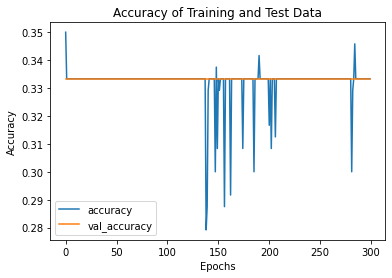

In [102]:
visualize_cnn(result[['accuracy', 'val_accuracy']], 'Accuracy of Training and Test Data', 'Accuracy')

In [103]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, input_shape = (120, 160, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'tanh'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation = 'softmax')
])
    
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

result = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 300)
result = pd.DataFrame(result.history) 

Train on 240 samples, validate on 60 samples
Epoch 1/300
240/240 [==============================] - 3s 13ms/sample - loss: 1.5515 - accuracy: 0.3875 - val_loss: 1.0548 - val_accuracy: 0.4000
Epoch 2/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.6791 - accuracy: 0.3083 - val_loss: 1.0452 - val_accuracy: 0.5333
Epoch 3/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.6102 - accuracy: 0.3625 - val_loss: 1.0274 - val_accuracy: 0.4000
Epoch 4/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.5429 - accuracy: 0.3583 - val_loss: 1.0089 - val_accuracy: 0.5500
Epoch 5/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.4553 - accuracy: 0.3625 - val_loss: 0.9835 - val_accuracy: 0.5000
Epoch 6/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.4776 - accuracy: 0.3792 - val_loss: 0.9281 - val_accuracy: 0.5833
Epoch 7/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.2631 

Epoch 57/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3043 - val_accuracy: 0.8667
Epoch 58/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3031 - val_accuracy: 0.8667
Epoch 59/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.2969 - val_accuracy: 0.8667
Epoch 60/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2936 - val_accuracy: 0.8667
Epoch 61/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3000 - val_accuracy: 0.8667
Epoch 62/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.3090 - val_accuracy: 0.8667
Epoch 63/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.3031 -

Epoch 113/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3555 - val_accuracy: 0.8667
Epoch 114/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3582 - val_accuracy: 0.8667
Epoch 115/300
240/240 [==============================] - 2s 9ms/sample - loss: 5.8027e-04 - accuracy: 1.0000 - val_loss: 0.3630 - val_accuracy: 0.8667
Epoch 116/300
240/240 [==============================] - 2s 9ms/sample - loss: 7.9416e-04 - accuracy: 1.0000 - val_loss: 0.3638 - val_accuracy: 0.8667
Epoch 117/300
240/240 [==============================] - 2s 9ms/sample - loss: 7.6481e-04 - accuracy: 1.0000 - val_loss: 0.3632 - val_accuracy: 0.8667
Epoch 118/300
240/240 [==============================] - 2s 9ms/sample - loss: 6.2585e-04 - accuracy: 1.0000 - val_loss: 0.3695 - val_accuracy: 0.8667
Epoch 119/300
240/240 [==============================] - 2s 9ms/sample - loss: 6.5227e-04 - accuracy: 

Epoch 168/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3946 - val_accuracy: 0.8667
Epoch 169/300
240/240 [==============================] - 2s 9ms/sample - loss: 4.8310e-04 - accuracy: 1.0000 - val_loss: 0.3969 - val_accuracy: 0.8667
Epoch 170/300
240/240 [==============================] - 2s 9ms/sample - loss: 4.5969e-04 - accuracy: 1.0000 - val_loss: 0.3943 - val_accuracy: 0.8667
Epoch 171/300
240/240 [==============================] - 2s 9ms/sample - loss: 3.9025e-04 - accuracy: 1.0000 - val_loss: 0.3875 - val_accuracy: 0.8667
Epoch 172/300
240/240 [==============================] - 2s 9ms/sample - loss: 6.4961e-04 - accuracy: 1.0000 - val_loss: 0.3875 - val_accuracy: 0.8667
Epoch 173/300
240/240 [==============================] - 2s 9ms/sample - loss: 3.8300e-04 - accuracy: 1.0000 - val_loss: 0.3878 - val_accuracy: 0.8667
Epoch 174/300
240/240 [==============================] - 2s 9ms/sample - loss: 4.1262e-04 - accura

240/240 [==============================] - 2s 9ms/sample - loss: 1.4757e-04 - accuracy: 1.0000 - val_loss: 0.4470 - val_accuracy: 0.8667
Epoch 277/300
240/240 [==============================] - 2s 9ms/sample - loss: 1.4179e-04 - accuracy: 1.0000 - val_loss: 0.4467 - val_accuracy: 0.8667
Epoch 278/300
240/240 [==============================] - 2s 9ms/sample - loss: 2.8088e-04 - accuracy: 1.0000 - val_loss: 0.4279 - val_accuracy: 0.8667
Epoch 279/300
240/240 [==============================] - 2s 9ms/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4133 - val_accuracy: 0.8500
Epoch 280/300
240/240 [==============================] - 2s 9ms/sample - loss: 2.1389e-04 - accuracy: 1.0000 - val_loss: 0.4060 - val_accuracy: 0.8500
Epoch 281/300
240/240 [==============================] - 2s 9ms/sample - loss: 5.4066e-04 - accuracy: 1.0000 - val_loss: 0.4052 - val_accuracy: 0.8500
Epoch 282/300
240/240 [==============================] - 2s 9ms/sample - loss: 3.5935e-04 - accuracy: 1.0000 - v

In [105]:
result

loss  accuracy  val_loss  val_accuracy
0    1.551516  0.387500  1.054810      0.400000
1    1.679054  0.308333  1.045199      0.533333
2    1.610188  0.362500  1.027444      0.400000
3    1.542854  0.358333  1.008916      0.550000
4    1.455302  0.362500  0.983524      0.500000
..        ...       ...       ...           ...
295  0.000152  1.000000  0.425782      0.866667
296  0.000860  1.000000  0.425414      0.866667
297  0.000206  1.000000  0.437826      0.866667
298  0.000114  1.000000  0.446452      0.866667
299  0.000109  1.000000  0.450792      0.866667

[300 rows x 4 columns]

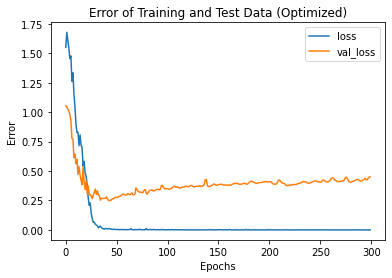

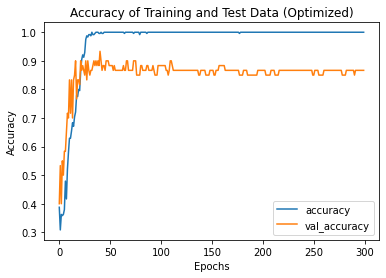

In [127]:
visualize_cnn(result[['loss', 'val_loss']], 'Error of Training and Test Data (Optimized)', 'Error')
visualize_cnn(result[['accuracy', 'val_accuracy']], 'Accuracy of Training and Test Data (Optimized)', 'Accuracy')